In [2]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))

import cupy as cp
from cupy.cuda import runtime
import pack_cuda
import pack_vis_sol

import kaggle_support as kgs
a=kgs.dill_load(kgs.code_dir + '../../results/many_ga/full/Baseline_4000_6d3f28a2_f.pkl')

local


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d//packing/code/core/../../results/many_ga/full/Baseline_4000_6d3f28a2_f.pkl'

<Axes: >

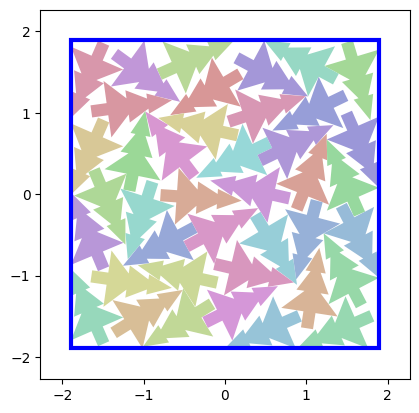

In [ ]:
pack_vis_sol.pack_vis_sol(a.result_ga.best_individual_legalized[0])

In [4]:
import pack_io
import pandas as pd
[sol_list_ref, scores] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))
#[sol_list_ref2, scores2] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))
#for s in sol_list_ref:
#    s.rotate(-np.pi/2)

In [6]:
scores[39]

0.3655570032925072

In [3]:
import numpy as np
(3.8/np.sqrt(40)*np.sqrt(200))**2/200

np.float64(0.361)

In [4]:
import numpy as np
np.sqrt(0.35*200)

np.float64(8.366600265340756)

In [3]:
3.85**2/40

0.3705625

In [3]:
#6.71**2/X = 0.35
X = 7.019617**2/0.35
X

140.78577950482574

In [2]:
import numpy as np
3.83/np.sqrt(40)

np.float64(0.6055761719222447)